In [4]:
import dgl
import numpy as np
import networkx as nx
import torch as T
import torch.nn as nn
import torch.nn.functional as F
from dgl.nn.pytorch import GraphConv
from dgl.nn import SAGEConv
import dgl.nn
import itertools
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from torch.autograd import Variable

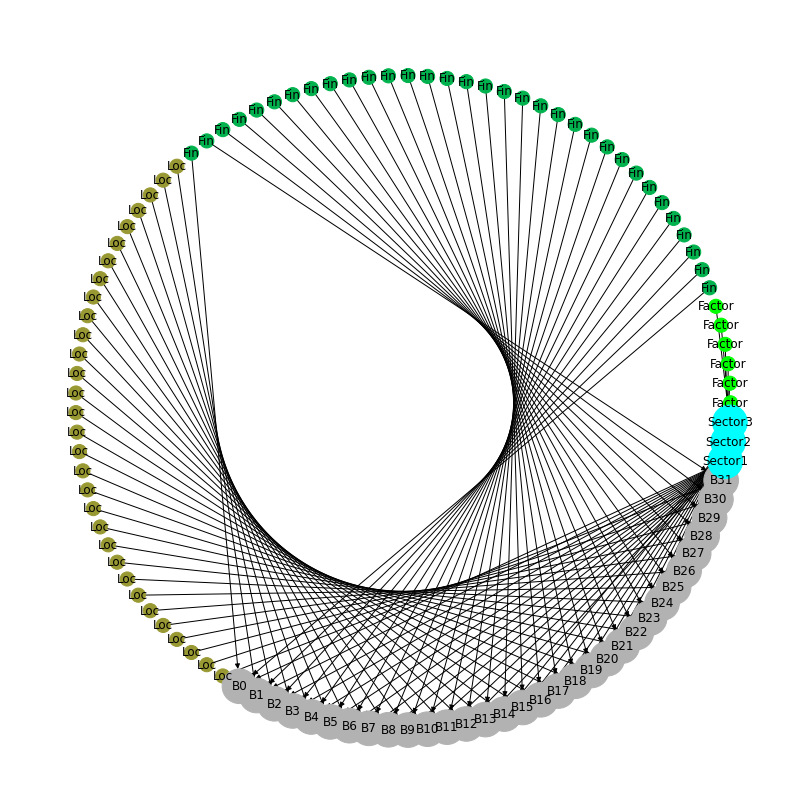

In [419]:
def build_borrower_sector_graph():

    
    b_s_src = np.array([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31])
    b_s_dst = np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,2,2,2,2,2,2,2])
    
    
    data_dict = {
    ('sector', 'belongs to', 'borrower'): (T.tensor(b_s_dst), T.tensor(b_s_src)),
    ('Fin', 'depends', 'borrower'): (T.arange(0,32), T.arange(0,32)),
    ('Loc', 'are', 'borrower'): (T.arange(0,32), T.arange(0,32)),
    ('Factor', 'effect', 'sector'): (T.tensor([0,1,2,3,4,5]), T.tensor([0,0,1,1,2,2]))
    }

    return dgl.heterograph(data_dict)

G = build_borrower_sector_graph()
G_homo = dgl.to_homogeneous(G)
nx_G = G_homo.to_networkx()
pos = nx.circular_layout(nx_G)

codes = []
for i in range(G_homo.num_nodes()):
    if i <6:
        codes.append(3)
    elif i >=6 and i<=38:
        codes.append(6)
    elif i>38 and i<70:
        codes.append(5)
    elif i>=70 and i<102:
        codes.append(0)
    else:
        codes.append(2)
        
colors = T.tensor([[.7, .7, .7],[1,.7,.1],[0,1,1],[0,1,0],[1,0,0],[.6,.6,.2],[0,.7,.3]])

plt.figure(figsize=(11, 11))
node_sizes = []
for i in range(G_homo.num_nodes()):
    if i <6:
        node_sizes.append(200)
    elif i >=6 and i<=38:
        node_sizes.append(200)
    elif i>38 and i<70:
        node_sizes.append(200)
    elif i>=70 and i<102:
        node_sizes.append(1200)
    else:
        node_sizes.append(1200)
        
labels = {}
for i in range(G_homo.num_nodes()):
    if i <6:
        labels.update({i : "Factor"})
    elif i >=6 and i<=38:
        labels.update({i : "Fin"})
    elif i>38 and i<70:
        labels.update({i : "Loc"})
    elif i>=70 and i<102:
        labels.update({i : "B"+str(i-70)})
    else:
        labels.update({i : "Sector"+str(i-101)})

nx.draw(nx_G, pos, node_size = node_sizes, with_labels=False, node_color=colors[codes])
D = nx.draw_networkx_labels(nx_G, pos,labels)

In [425]:
def Loss_Function(embeddings, target_centers, centers, epoch):
    
    next_target = []
    for i in range(len(embeddings)):

        cluster = target_centers[i]
        
        if len(centers) != 1: 
            dist = []
            C = []
            for m in centers:
                d = np.square(embeddings.detach().numpy()[i] - m.detach().numpy()).mean()
                dist.append(d)
                C.append(m)
                
            
            tup = list(zip(dist,C))
            lst = len(tup) 
            for i in range(0, lst): 

                for j in range(0, lst-i-1): 
                    if (tup[j][0] > tup[j + 1][0]): 
                        temp = tup[j] 
                        tup[j]= tup[j + 1] 
                        tup[j + 1]= temp
            
            next_c = tup[1][1]
        else:
            next_c = centers[0]
            
        
        next_target.append(next_c.detach().numpy())
    
    next_target = T.tensor(next_target)
    
    b = T.sum((embeddings - next_target)**2,1) 
    a = T.sum((embeddings - target_centers)**2,1)
    
#     a = a/T.max(a)
#     b = b/T.max(b)
    
#     print("a ", T.sum(a))
#     print("b ", T.sum(b))
    
    return T.sum((a - b)**2)                 #/T.max(T.sum(a),T.sum(b))
    

In [426]:
class RGCN(nn.Module):
    def __init__(self, in_feats, hid_feats, out_feats, L1_names, L2_names):
        super().__init__()

        self.conv1 = dgl.nn.HeteroGraphConv({rel: SAGEConv(in_feats, hid_feats, 'mean', norm = None, activation = None, bias = False) for rel in L1_names}, aggregate='sum')
        self.conv2 = dgl.nn.HeteroGraphConv({rel: SAGEConv(hid_feats, out_feats, 'mean', norm = None, activation = None, bias = False) for rel in L2_names}, aggregate='sum')

    def forward(self, graph, inputs):
        l1_inputs = {'Factor' : inputs['Factor'], 'sector' : inputs['sector'], 'borrower' : inputs['borrower']}
        h = self.conv1(graph, l1_inputs)
        #print("layer 1 : ",h)
        h = {k: F.leaky_relu(v) for k, v in h.items()}
        #print("Relu : ",h)
        l2_inputs = {'sector' : h['sector'], 'borrower' : inputs['borrower'], 'Loc' : inputs['Loc'], 'Fin' : inputs['Fin']}
        h = self.conv2(graph, l2_inputs)
        #print("layer 2 : ",h)
        return h
    


In [431]:
model = RGCN(1, 1, 2, [ 'belongs to', 'effect'],['belongs to', 'depends', 'are'])


G.nodes['borrower'].data['f'] = T.tensor([[0],[0],[0],[1.],[1.],
                                          [1.],[1.],[1.],[1.],[1.],
                                          [1.],[1.],[1.],[1.],[1.],
                                          [1.],[1.],[1.],[1.],[1.],
                                          [1.],[1.],[1.],[1.],[1.],
                                          [1.],[1.],[10.],[10.],[1.],
                                          [1.],[1.]])

G.nodes['Fin'].data['f'] = T.tensor([[1.],[1.],[1.],[1.],[1.],
                                          [1.],[1.],[1.],[1.],[1.],
                                          [1.],[1.],[1.],[1.],[1.],
                                          [1.],[1.],[1.],[1.],[1.],
                                          [1.],[1.],[1.],[1.],[1.],
                                          [1.],[1.],[1.],[1.],[1.],
                                          [1.],[1.]])

G.nodes['Loc'].data['f'] = T.tensor([[1.],[1.],[1.],[1.],[1.],
                                          [1.],[1.],[1.],[1.],[1.],
                                          [1.],[1.],[1.],[1.],[1.],
                                          [1.],[1.],[1.],[1.],[1.],
                                          [1.],[1.],[1.],[1.],[1.],
                                          [1.],[1.],[1.],[1.],[1.],
                                          [1.],[1.]])

G.nodes['Factor'].data['f'] = T.tensor([[1.],[1.],[1.],[1.],[1.],[10.]])

G.nodes['sector'].data['f'] = T.tensor([[10.],[1.],[1.]])

In [432]:
# model = RGCN(1, 1, 2, [ 'belongs to', 'effect'],['belongs to', 'depends', 'are'])

# G.nodes['borrower'].data['f'] = T.normal(1, 1, size=(32, 1))
# G.nodes['Fin'].data['f'] = T.normal(1, 1, size=(32, 1))
# G.nodes['Loc'].data['f'] = T.normal(1, 1, size=(32, 1))
# G.nodes['Factor'].data['f'] = T.normal(1, 1, size=(6, 1))
# G.nodes['sector'].data['f'] = T.normal(1, 1, size=(3, 1))

centers  tensor([[-22.9292, -13.4033],
        [ -4.2023,  -5.5682],
        [  1.0966, -19.3820],
        [-16.4964, -10.7119]])


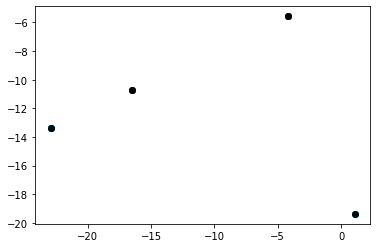

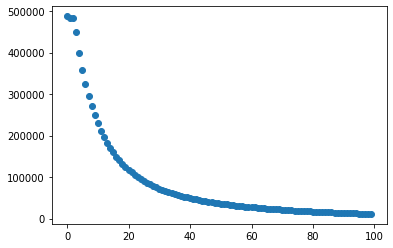

centers  tensor([[-15.8226, -14.0339],
        [ -3.4692,  -5.9558],
        [ -1.7198, -11.0357],
        [-14.2215, -12.9870]])
borrower  tensor([[-15.8226, -14.0339],
        [-15.8226, -14.0339],
        [-15.8226, -14.0339],
        [-15.8226, -14.0339],
        [-15.8226, -14.0339],
        [-15.8226, -14.0339],
        [-15.8226, -14.0339],
        [-15.8226, -14.0339],
        [-15.8226, -14.0339],
        [-15.8226, -14.0339],
        [-15.8226, -14.0339],
        [-15.8226, -14.0339],
        [-15.8226, -14.0339],
        [-15.8226, -14.0339],
        [ -3.4692,  -5.9558],
        [ -3.4692,  -5.9558],
        [ -3.4692,  -5.9558],
        [ -3.4692,  -5.9558],
        [ -3.4692,  -5.9558],
        [ -3.4692,  -5.9558],
        [ -3.4692,  -5.9558],
        [ -3.4692,  -5.9558],
        [ -3.4692,  -5.9558],
        [ -3.4692,  -5.9558],
        [ -3.4692,  -5.9558],
        [-14.2215, -12.9870],
        [-14.2215, -12.9870],
        [ -1.7198, -11.0357],
        [ -1.7198, -

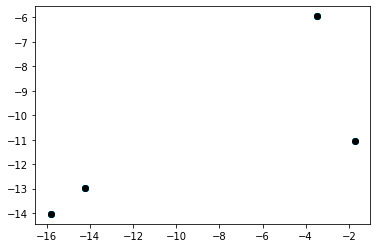

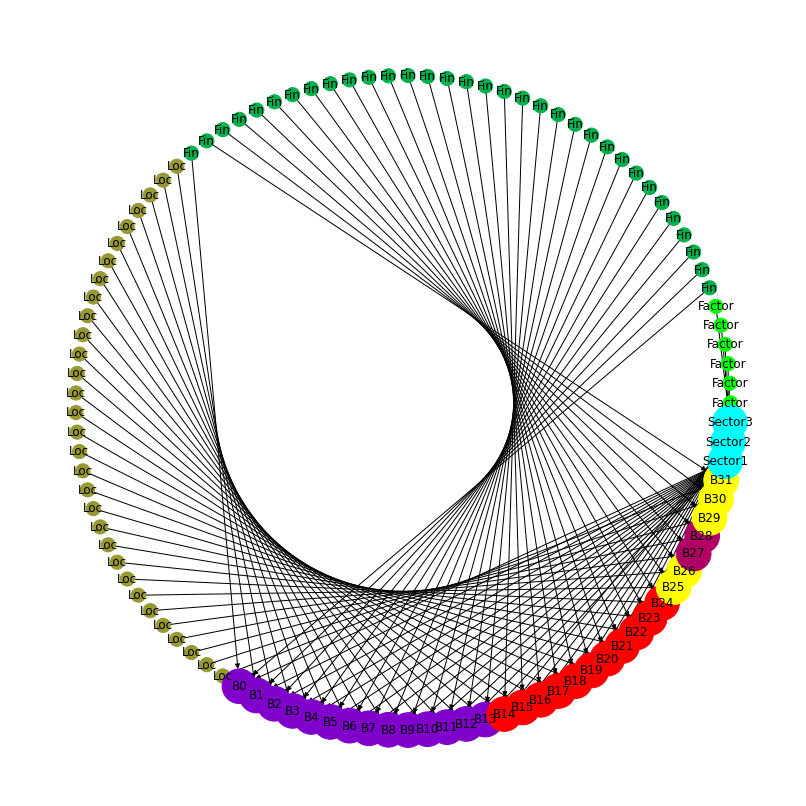

In [433]:
borrower_feats = G.nodes['borrower'].data['f']
sector_feats = G.nodes['sector'].data['f']
fin_feats = G.nodes['Fin'].data['f']
loc_feats = G.nodes['Loc'].data['f']
factor_feats = G.nodes['Factor'].data['f']

node_features = {'borrower':borrower_feats,'sector':sector_feats,'Fin':fin_feats,'Loc':loc_feats,'Factor':factor_feats}
opt = T.optim.Adam(model.parameters(),lr=0.01)

clusters = 4
Loss = []
epochs = 100

for epoch in range(epochs):
    
    model.train()
    logits = model(G, node_features)
    
    X = logits['borrower'].detach().numpy()
    kmeans = KMeans(n_clusters=clusters, random_state=0).fit(X)
    centers = kmeans.cluster_centers_
    
    target_centers = []
    for i in X:
        l = []
        for j in centers:
            mse = np.square(i - j).mean()
            l.append(mse)
        
        target_centers.append(l.index(min(l)))
        
        
    centers = T.tensor(centers)
    target_centers = centers[T.tensor(target_centers)]
    
    if epoch == 0:
        print("centers ", centers)
        #print("borrower ", logits['borrower'])
        plt.scatter(X[:,0], X[:,1], color = 'deepskyblue')
        plt.scatter(centers[:,0], centers[:,1],color = 'k')
        plt.show()
        
    loss = F.mse_loss(logits['borrower'], target_centers)
    #l = my_loss(logits['borrower'],target_centers,centers)
    score = Loss_Function(logits['borrower'], target_centers, centers,epoch)
    Loss.append(score.tolist())

    
    opt.zero_grad()
    score.backward()
    opt.step()



plt.scatter(list(range(len(Loss))),Loss)
plt.show()

print("centers ", centers)
print("borrower ", logits['borrower'])
plt.scatter(X[:,0], X[:,1],color = 'deepskyblue')
plt.scatter(centers[:,0], centers[:,1],color = 'k')
plt.show()

# s = Silhouette_Score(logits['borrower'], target_centers, centers)
# print("Silhouette Score: ",s)

#print(logits)
b_colors = T.tensor([[.5,0,.8],[1,0,0],[.7,0,.4],[1,1,0],[.2,.7,.4]])
o_colors = T.tensor([[.7, .7, .7],[1,.7,.1],[0,1,1],[0,1,0],[1,0,0],[.6,.6,.2],[0,.7,.3]])

X = logits['borrower'].detach().numpy()
kmeans = KMeans(n_clusters=clusters, random_state=0).fit(X)

prediction = T.tensor(kmeans.predict(X)).long()

colors = T.cat((o_colors[codes[:70]],b_colors[prediction]))

plt.figure(figsize=(11, 11))
nx.draw(nx_G, pos, node_size = node_sizes, with_labels=False, node_color=T.cat((colors,o_colors[[2,2,2]])))
D = nx.draw_networkx_labels(nx_G, pos,labels)

In [430]:
import dgl
graph = dgl.heterograph({
    ('games', 'are', 'addictive') : (T.tensor([0,0,1,2,2]), T.tensor([0,1,2,3,4])),
    ('user', 'plays', 'games') : (T.tensor([0,1,2,3]), T.tensor([0,1,2,3])),
    ('store', 'sells', 'games')  : (T.tensor([0,0,1,1]), T.tensor([0,1,2,3]))
                                 })

In [238]:

conv = dgl.nn.HeteroGraphConv({
    'are' : dgl.nn.GraphConv(1,2, norm = 'none'),
    'plays' : dgl.nn.GraphConv(1,2, norm = 'none')},
    #'sells' : dgl.nn.GraphConv(1,5)},
    aggregate='sum')


In [239]:
graph.nodes['store'].data['f'] = T.tensor([[10.],[10.]])

graph.nodes['games'].data['f'] = T.tensor([[10.],[10.],[10.],[10.]])

graph.nodes['user'].data['f'] = T.tensor([[10.],[10.],[10.],[10.]])

graph.nodes['addictive'].data['f'] = T.tensor([[10.],[10.],[10.],[10.],[10.]])

In [240]:
h1 = {'user' : graph.nodes['user'].data['f'], 'games' : graph.nodes['games'].data['f'],
      'addictive' : graph.nodes['addictive'].data['f']}

h2 = { 'games' : graph.nodes['games'].data['f'],'addictive' : graph.nodes['addictive'].data['f']}

h3 = conv(graph, h1)
print(h3)

{'addictive': tensor([[ 7.2440, -8.7872],
        [ 7.2440, -8.7872],
        [ 7.2440, -8.7872],
        [ 7.2440, -8.7872],
        [ 7.2440, -8.7872]], grad_fn=<SumBackward1>), 'games': tensor([[12.7853,  7.8371],
        [12.7853,  7.8371],
        [12.7853,  7.8371],
        [12.7853,  7.8371]], grad_fn=<SumBackward1>)}


In [389]:
g = dgl.graph(([0,1,2,3,4,5], [1,2,3,4,5,6]))
#g = dgl.add_self_loop(g)
feat = T.tensor([[10., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.]])
conv = GraphConv(5, 2, norm='none', weight=False, bias=False, allow_zero_in_degree=True)
res = conv(g, feat)
# print(g.in_degrees())
# print(g.out_degrees())
print(res)

conv = GraphConv(10, 2, norm='both', weight=False, bias=False, allow_zero_in_degree=True)
res = conv(g, feat)
print(res)


tensor([[ 0.,  0.,  0.,  0.,  0.],
        [10.,  1.,  1.,  1.,  1.],
        [ 1.,  1.,  1.,  1.,  1.],
        [ 1.,  1.,  1.,  1.,  1.],
        [ 1.,  1.,  1.,  1.,  1.],
        [ 1.,  1.,  1.,  1.,  1.],
        [ 1.,  1.,  1.,  1.,  1.]])
tensor([[ 0.,  0.,  0.,  0.,  0.],
        [10.,  1.,  1.,  1.,  1.],
        [ 1.,  1.,  1.,  1.,  1.],
        [ 1.,  1.,  1.,  1.,  1.],
        [ 1.,  1.,  1.,  1.,  1.],
        [ 1.,  1.,  1.,  1.,  1.],
        [ 1.,  1.,  1.,  1.,  1.]])


In [391]:
from dgl.nn import SAGEConv


# Case 1: Homogeneous graph
g = dgl.graph(([0,1,2,3,4,5], [1,2,3,4,5,6]))
feat = T.tensor([[1000., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
conv = SAGEConv(10, 2, 'mean', norm = None , activation = None, bias = False)
res = conv(g, feat)
res

tensor([[4.0975e+02, 5.8211e+02],
        [9.1013e+02, 1.5177e+02],
        [4.8078e+00, 3.7492e-01],
        [4.8078e+00, 3.7492e-01],
        [4.8078e+00, 3.7492e-01],
        [4.8078e+00, 3.7492e-01],
        [4.8078e+00, 3.7492e-01]], grad_fn=<AddBackward0>)